In [ ]:
!rm -rf *

!wget https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531851/20210228%E6%95%B0%E6%8D%AE%E6%9B%B4%E6%96%B0/gaiic_track3_round1_train_20210228.zip
!wget https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531851/20210228%E6%95%B0%E6%8D%AE%E6%9B%B4%E6%96%B0/gaiic_track3_round1_testA_20210228.zip


!unzip -q /content/gaiic_track3_round1_testA_20210228.zip
!unzip -q /content/gaiic_track3_round1_train_20210228.zip

!rm -rf /content/sample_data
!rm -rf *.zip

--2021-03-26 18:25:21--  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531851/20210228%E6%95%B0%E6%8D%AE%E6%9B%B4%E6%96%B0/gaiic_track3_round1_train_20210228.zip
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)|118.31.232.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1788971 (1.7M) [application/zip]
Saving to: ‘gaiic_track3_round1_train_20210228.zip’

gaiic_track3_round1 100%[===================>]   1.71M   751KB/s    in 2.3s    

2021-03-26 18:25:26 (751 KB/s) - ‘gaiic_track3_round1_train_20210228.zip’ saved [1788971/1788971]

--2021-03-26 18:25:26--  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531851/20210228%E6%95%B0%E6%8D%AE%E6%9B%B4%E6%96%B0/gaiic_track3_round1_testA_20210228.zip
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.co

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os

import logging
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from collections import Counter

from lightgbm import LGBMClassifier

In [ ]:
df_train = pd.read_table("gaiic_track3_round1_train_20210228.tsv", names=['q1', 'q2', 'label']).fillna("0")
df_test = pd.read_table('gaiic_track3_round1_testA_20210228.tsv', names=['q1', 'q2']).fillna("0")

In [ ]:
df_train.head()

,q1,q2,label
0,1 2 3 4 5 6 7,8 9 10 4 11,0
1,12 13 14 15,12 15 11 16,0
2,17 18 12 19 20 21 22 23 24,12 23 25 6 26 27 19,1
3,28 29 30 31 11,32 33 34 30 31,1
4,29 35 36 29,29 37 36 29,1


In [ ]:
df_test.head()

,q1,q2
0,12 23 4160 276,29 23 169 1495
1,12 5 239 243 29 1001 126 1405 11,29 485 12 251 1405 11
2,134 1059 3028 9268 32 39 9 6040 322,3028 9268 2797 7318 126 16
3,169 718 249 23 1560 90 533,246 247 1795
4,1847 1600 457 1322 243 240 416 19 3052 1006,240 416 1231 422 2323


In [ ]:
df_train['label'].value_counts()

0    63564
1    36436
Name: label, dtype: int64

Populating the interactive namespace from numpy and matplotlib
0    63564
1    36436
Name: label, dtype: int64


Text(0.5, 0, 'category')

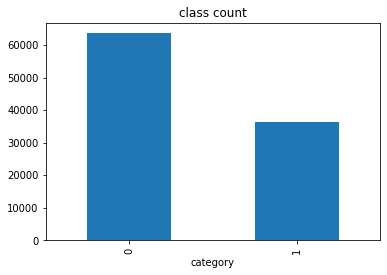

In [ ]:
%pylab inline
print(df_train['label'].value_counts())
df_train['label'].value_counts().plot(kind='bar')
plt.title('class count')
plt.xlabel("category")

In [ ]:
label = df_train['label'].values
df = pd.concat([df_train, df_test], ignore_index=True)
df['text'] = df['q1'] + " " + df['q2']

In [ ]:
#  字符串拆分城数字
def str2char():
    txt = df['text'].apply(lambda x: list(x.split()))
    x = []   
    for i in (range(0, len(txt))):
        x.append(txt[i])
        y = x[i]   
        for j in range(len(y)):
            df['str2char_{}'.format(j)] = 0

    for i in (range(0, len(txt))):
        x.append(txt[i])
        y = x[i]       
        for value, idx in zip(y, range(len(y))):
            df['str2char_{}'.format(idx)][i] = value
str2char()

#   q1、q2 字符串中的相同字符个数
def dup_num():
    a = df['q1'].apply(lambda x: (x.split()))
    b = df['q2'].apply(lambda x: (x.split()))
    x = []
    for i in range(len(a)):
        x.append(len(set(a[i]) & set(b[i])))
    df['dup_num']=pd.DataFrame(x)
    return df['dup_num']
df['dup_num'] = dup_num()

#   q1、q2 字符串中的相同字符
def dup_chr():
    a = df['q1'].apply(lambda x: list(x.split()))
    b = df['q2'].apply(lambda x: list(x.split()))
    x = []   
    for i in (range(0, len(a))):
        x.append(set(a[i]) & set(b[i]))
        y = x[i]       
        for  idx in  range(len(y)):
            df['dup_chr_{}'.format(idx)] = 0

    for i in (range(0, len(a))):
        x.append(set(a[i]) & set(b[i]))
        y = x[i]       
        for value, idx in zip(y, range(len(y))):
            df['dup_chr_{}'.format(idx)][i] = value
dup_chr()

# 长度
df['q1_len']   = df['q1'].apply(lambda x: len(x.split(' '))) 
df['q2_len']   = df['q2'].apply(lambda x: len(x.split(' '))) 
df['text_len'] = df['text'].apply(lambda x: len(x.split(' '))) 

# q1 q2长度差
df['sub_q1q2'] = df['q1_len'] - df['q2_len']
df['sub_q2q1'] = df['q2_len'] - df['q1_len']

# 出现的最大值
df['max_q1']     = df['q1'].apply(lambda x: max(list(map(int, x.split()))))
df['max_q2']     = df['q2'].apply(lambda x: max(list(map(int, x.split()))))
df['max_text'] = df['text'].apply(lambda x: max(list(map(int, x.split()))))

# 出现的最小值
df['min_q1']     = df['q1'].apply(lambda x: min(list(map(int, x.split()))))
df['min_q2']     = df['q2'].apply(lambda x: min(list(map(int, x.split()))))
df['min_text'] = df['text'].apply(lambda x: min(list(map(int, x.split()))))

# max-min
df['max_min_q1']     = df['max_q1'] - df['min_q1']
df['max_min_q2']     = df['max_q2'] - df['min_q2']
df['max_min_text'] = df['max_text'] - df['min_text']

# mean值
df['mean_q1']     = df['q1'].apply(lambda x: mean(list(map(int, x.split()))))
df['mean_q2']     = df['q2'].apply(lambda x: mean(list(map(int, x.split()))))
df['mean_text'] = df['text'].apply(lambda x: mean(list(map(int, x.split()))))

# std值
df['std_q1']     = df['q1'].apply(lambda x: std(list(map(int, x.split()))))
df['std_q2']     = df['q2'].apply(lambda x: std(list(map(int, x.split()))))
df['std_text'] = df['text'].apply(lambda x: std(list(map(int, x.split()))))

# freq 出现的最大频率
df['freq_q1']     = df['q1'].apply(lambda x: max(((Counter(list(map(int, x.split()))))).values()))
df['freq_q2']     = df['q2'].apply(lambda x: max(((Counter(list(map(int, x.split()))))).values()))
df['freq_text'] = df['text'].apply(lambda x: max(((Counter(list(map(int, x.split()))))).values()))

In [ ]:
df[0:9]

,q1,q2,label,text,str2char_0,str2char_1,str2char_2,str2char_3,str2char_4,str2char_5,str2char_6,str2char_7,str2char_8,str2char_9,str2char_10,str2char_11,str2char_12,str2char_13,str2char_14,str2char_15,str2char_16,str2char_17,str2char_18,str2char_19,str2char_20,str2char_21,str2char_22,str2char_23,str2char_24,str2char_25,str2char_26,str2char_27,str2char_28,str2char_29,str2char_30,str2char_31,str2char_32,str2char_33,str2char_34,str2char_35,...,str2char_87,str2char_88,str2char_89,dup_num,dup_chr_0,dup_chr_1,dup_chr_2,dup_chr_3,dup_chr_4,dup_chr_5,dup_chr_6,dup_chr_7,dup_chr_8,dup_chr_9,dup_chr_10,dup_chr_11,dup_chr_12,q1_len,q2_len,text_len,sub_q1q2,sub_q2q1,max_q1,max_q2,max_text,min_q1,min_q2,min_text,max_min_q1,max_min_q2,max_min_text,mean_q1,mean_q2,mean_text,std_q1,std_q2,std_text,freq_q1,freq_q2,freq_text
0,1 2 3 4 5 6 7,8 9 10 4 11,0.0,1 2 3 4 5 6 7 8 9 10 4 11,1,2,3,4,5,6,7,8,9,10,4,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,7,5,12,2,-2,7,11,11,1,4,1,6,7,10,4.000000,8.400000,5.833333,2.000000,2.416609,3.077698,1,1,2
1,12 13 14 15,12 15 11 16,0.0,12 13 14 15 12 15 11 16,12,13,14,15,12,15,11,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,15,12,0,0,0,0,0,0,0,0,0,0,0,4,4,8,0,0,15,16,16,12,11,11,3,5,5,13.500000,13.500000,13.500000,1.118034,2.061553,1.658312,1,1,2
2,17 18 12 19 20 21 22 23 24,12 23 25 6 26 27 19,1.0,17 18 12 19 20 21 22 23 24 12 23 25 6 26 27 19,17,18,12,19,20,21,22,23,24,12,23,25,6,26,27,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,23,19,12,0,0,0,0,0,0,0,0,0,0,9,7,16,2,-2,24,27,27,12,6,6,12,21,21,19.555556,19.714286,19.625000,3.435472,7.362342,5.509934,1,1,2
3,28 29 30 31 11,32 33 34 30 31,1.0,28 29 30 31 11 32 33 34 30 31,28,29,30,31,11,32,33,34,30,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,30,31,0,0,0,0,0,0,0,0,0,0,0,5,5,10,0,0,31,34,34,11,30,11,20,4,23,25.800000,32.000000,28.900000,7.467262,1.414214,6.204031,1,1,2
4,29 35 36 29,29 37 36 29,1.0,29 35 36 29 29 37 36 29,29,35,36,29,29,37,36,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,29,36,0,0,0,0,0,0,0,0,0,0,0,4,4,8,0,0,36,37,37,29,29,29,7,8,8,32.250000,32.750000,32.500000,3.269174,3.766630,3.535534,2,2,4
5,38 23 39 9 40,12 19 41 42 23 43 12 23 44 41 42 19,0.0,38 23 39 9 40 12 19 41 42 23 43 12 23 44 41 42 19,38,23,39,9,40,12,19,41,42,23,43,12,23,44,41,42,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,23,0,0,0,0,0,0,0,0,0,0,0,0,5,12,17,-7,7,40,44,44,9,12,9,31,32,35,29.800000,30.083333,30.000000,12.122706,12.526361,12.409674,1,2,3
6,45 46 47 48 49 50 45 48 51 32 52 53 54,55 46 47 48 49 56 57 58 59,0.0,45 46 47 48 49 50 45 48 51 32 52 53 54 55 46 4...,45,46,47,48,49,50,45,48,51,32,52,53,54,55,46,47,48,49,56,57,58,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,46,47,49,48,0,0,0,0,0,0,0,0,0,13,9,22,4,-4,54,59,59,32,46,32,22,13,27,47.692308,52.777778,49.772727,5.326055,4.893937,5.728175,2,1,3
7,12 60 61 29,12 61 29,1.0,12 60 61 29 12 61 29,12,60,61,29,12,61,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,29,61,12,0,0,0,0,0,0,0,0,0,0,4,3,7,1,-1,61,61,61,12,12,12,49,49,49,40.500000,34.000000,37.714286,20.886599,20.314199,20.892338,1,1,2
8,12 62 43 29 63 11,29 64 12 62 43 65 11 66,1.0,12 62 43 29 63 11 29 64 12 62 43 65 11 66,12,62,43,29,63,11,29,64,12,62,43,65,11,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5,62,11,29,43,12,0,0,0,0,0,0,0,0,6,8,14,-2,2,63,66,66,11,11,11,52,55,55,36.666667,44.000000,40.857143,21.218441,22.327114,22.158059,1,1,2


In [ ]:
#数据分布情况统计
print(df['text_len'].describe()) 

count    125000.000000
mean         12.858536
std           4.406806
min           3.000000
25%          10.000000
50%          12.000000
75%          15.000000
max          90.000000
Name: text_len, dtype: float64


Text(0.5, 1.0, 'Histogram of char count')

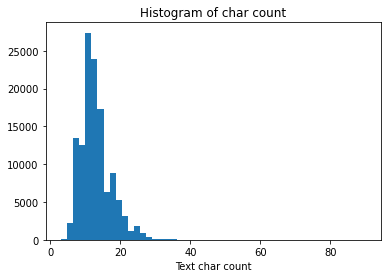

In [ ]:
_ = plt.hist(df['text_len'], bins=50)
plt.xlabel('Text char count')
plt.title("Histogram of char count")

In [ ]:
all_lines = ' '.join(list(df['text']))
word_count = Counter(all_lines.split(" "))
word_count = sorted(word_count.items(), key=lambda d:d[1], reverse = True)

# 总字数
print('all: ',len(word_count))
# 最多
print('max: ',word_count[0])
# 最少
print('min: ', word_count[-1])

all:  20600
max:  ('12', 97064)
min:  ('20273', 1)


In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 5))
tfidf_feature = tfidf.fit_transform(df['text'])
svd_feature = TruncatedSVD(n_components=100).fit_transform(tfidf_feature)


train_df = svd_feature[:-len(df_test)]
test_df = svd_feature[-len(df_test):]

In [ ]:
extra_data = np.array(df[df.columns[4:]])
append_train = extra_data[:-len(df_test)]
append_test = extra_data[-len(df_test):]
print(append_train.shape[0], append_train.shape[1])

100000 127


In [ ]:
# extra 特征
train_df_np = np.hstack((train_df, append_train))
test_df_np  = np.hstack((test_df,  append_test))

In [ ]:
train_df_np.shape

In [ ]:
train_df, test_df = train_df_np, test_df_np

In [ ]:
import lightgbm as lgb

scores = []

nfold = 5
kf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

lr_oof = np.zeros((len(df_train), 2))
lr_predictions = np.zeros((len(df_test), 2))

i = 0
for train_index, valid_index in kf.split(train_df, label):
    print("\nFold {}".format(i + 1))
    X_train, label_train = train_df[train_index], label[train_index]
    X_valid, label_valid = train_df[valid_index], label[valid_index]


    model = lgb.LGBMClassifier(num_leaves=31, max_depth=13, n_estimators=100000, learning_rate=0.05, verbose=-1, metric='auc')
    model.fit(X_train, label_train, eval_set = [(X_valid, label_valid)], early_stopping_rounds=300, verbose=600)


    lr_oof[valid_index] = model.predict_proba(X_valid,)
    scores.append(roc_auc_score(label_valid, lr_oof[valid_index][:,1]))
    
    lr_predictions += model.predict_proba(test_df) / nfold
    i += 1
    print(scores)
    
print(np.mean(scores))

In [ ]:
pd.DataFrame(lr_predictions[:,1]).to_csv("./result.csv", index=False, header=False)

In [ ]:
!zip result.csv.zip ./result.csv